In [16]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
import math


from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

# Урок 5. Случайный лес

In [17]:
# реализуем генерацию N бутстрап-выборок

random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [18]:
# реализуем генерацию подмножества признаков для нахождения разбиения в узле


def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    subsample = sample_indexes[0:len_subsample].copy()
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    return subsample

In [19]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [20]:

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [21]:
# добавим функцию формирования случайного леса.

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [22]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [23]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [24]:
# сгенерируем данные, представляющие собой 100 объектов с 2-я признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                     n_clusters_per_class=1, random_state=53)

train_data = classification_data.copy()
train_labels = classification_labels.copy()

In [25]:
# 1 дерево
my_forest_1 = random_forest(train_data, train_labels, 1)
train_answers_1 = tree_vote(my_forest_1, train_data)
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)

# 3 дерева
my_forest_3 = random_forest(train_data, train_labels, 3)
train_answers_3 = tree_vote(my_forest_3, train_data)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)

# 10 деревьев
my_forest_10 = random_forest(train_data, train_labels, 10)
train_answers_10 = tree_vote(my_forest_10, train_data)
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)

# 50 деревьев
my_forest_50 = random_forest(train_data, train_labels, 50)
train_answers_50 = tree_vote(my_forest_50, train_data)
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)

<Figure size 1152x504 with 0 Axes>

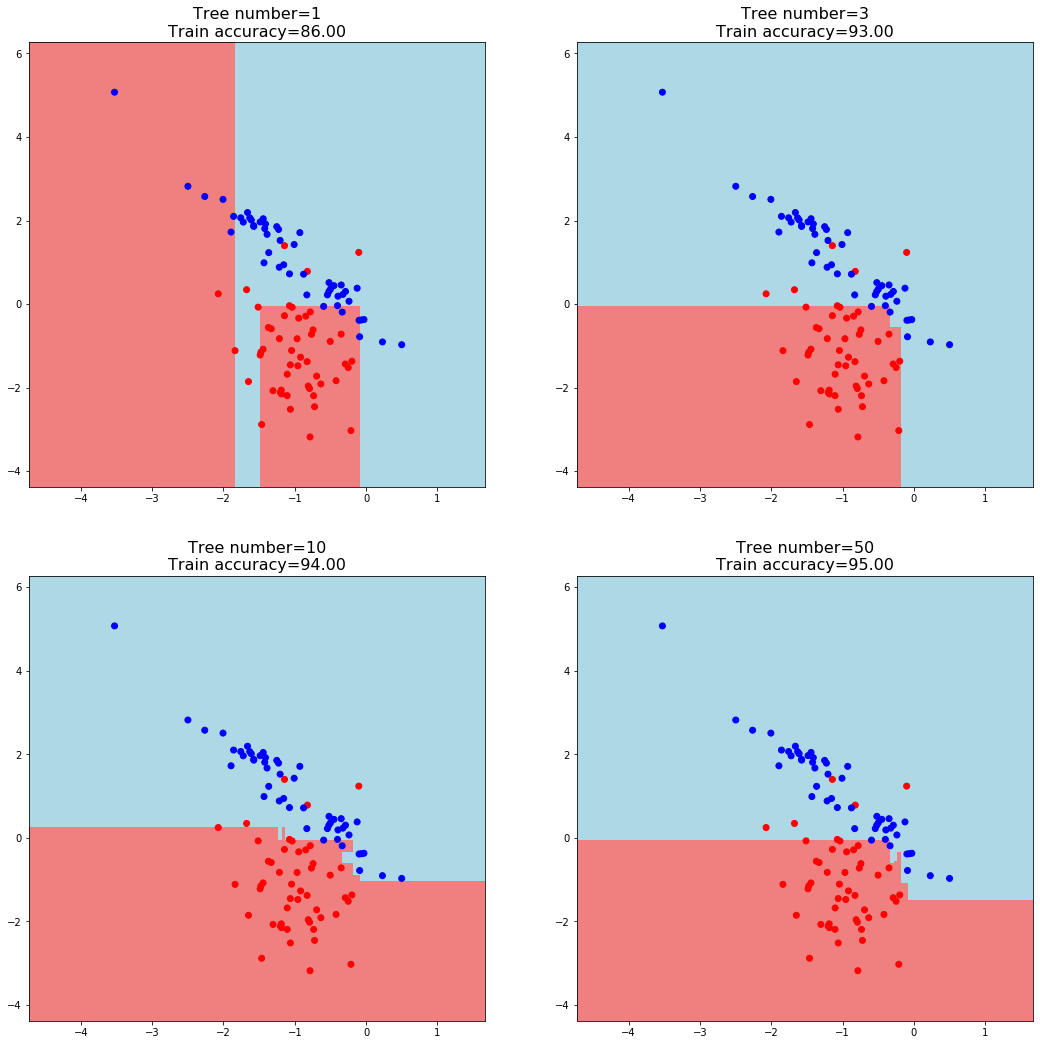

In [26]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize = (16, 7))

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18, 18)

# график обучающей выборки для 1 дерева
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[0, 0].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
axs[0, 0].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
axs[0, 0].set_title(f'Tree number=1\nTrain accuracy={train_accuracy_1:.2f}', fontsize=16)

# график обучающей выборки для 3 деревьев
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[0, 1].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
axs[0, 1].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
axs[0, 1].set_title(f'Tree number=3\nTrain accuracy={train_accuracy_3:.2f}', fontsize=16)

# график обучающей выборки для 10 деревьев
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[1, 0].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
axs[1, 0].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
axs[1, 0].set_title(f'Tree number=10\nTrain accuracy={train_accuracy_10:.2f}', fontsize=16)

# график обучающей выборки для 50 деревьев
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
axs[1, 1].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
axs[1, 1].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
axs[1, 1].set_title(f'Tree number=50\nTrain accuracy={train_accuracy_50:.2f}', fontsize=16);

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

#### Сложность имеет прямую зависимость от количества деревьев.
#### Недообучение и переобучение не наблюдается. Все обученные модели достаточно хорошо описывают данные.

### 3*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [27]:
def get_bootstrap_2(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    # индексы объектов, которые попали в выборку    
    indexes = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        sample_indexes = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            sample_indexes.append(sample_index)
        bootstrap.append((b_data, b_labels))
        indexes.append(sample_indexes)
        
    return bootstrap, indexes

In [31]:
def random_forest_2(data, labels, n_trees):
    forest = []
    bootstrap, indexes = get_bootstrap_2(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, indexes

In [35]:
def oob_score(data, labels, oob_sample, forest):
    predictions = []
    actual = []
    
    for i in range(data.shape[0]):
        index_tree = []
        for idx, tree in enumerate(oob_sample):
            if i not in tree:
                index_tree.append(idx)
        if index_tree:
            new_forest = [forest[k] for k in index_tree]
            prediction = tree_vote(new_forest, [data[i]])[0]
            predictions.append(prediction)
            actual.append(labels[i])
    
    return accuracy_metric(actual, predictions)

In [40]:
# сгенерируем данные, представляющие собой 100 объектов с 2-я признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                     n_clusters_per_class=1, random_state=55)

# создаем одинаковые тестовую и обучающую выборки используя все исходные данные
train_data = classification_data.copy()
train_labels = classification_labels.copy()

# Обучим модель и запомним какие объекты использовались для обучения деревьев
n_trees = 10
my_forest_10, oob_indexes = random_forest_2(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки по стандартному алгоритму без Out-of-Bag
train_answers = tree_vote(my_forest_10, train_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке без Out-of-Bag: {train_accuracy:.3f}')

# Точность на тестовой выборке с использованием Out-of-Bag
oob_train_accuracy = oob_score(train_data, train_labels, oob_indexes, my_forest_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке с Out-of-Bag: {oob_train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке без Out-of-Bag: 96.000
Точность случайного леса из 10 деревьев на обучающей выборке с Out-of-Bag: 90.000


### 4*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [15]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    length = len(labels)
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / length
        
        if p == 0:
            continue
            
        entropy -= p * math.log(p, 2)
        
    return entropy